# Study by omnivorism category

In [1]:
import sys
sys.path.append("../src/")
import re
import random
import math
from collections import OrderedDict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PFEmodules import *
# For help on the stuff available in the PFEmodules: (uncomment to see help page)
#help(frequency)
#help(student)
#help(counters)
#help(distribution)
#help(fn)
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv("../data/data-prepped.csv")
df_tco=pd.read_csv("../data/df_tco.csv")
df_tcobay = pd.read_csv("../data/df_tcobay.csv")
df_tcbay = pd.read_csv("../data/df_tcbay.csv")
try:
    df.drop(columns=["Unnamed: 0"], inplace=True)
except:
    pass
else:
    print("operation performed")
for frame in [df_tco, df_tcbay, df_tcobay]:
    frame.drop(columns="Unnamed: 0", inplace=True)
Counter = DataframeCounter(df)

operation performed


In [3]:
df_cat = df_tco
df_cat["CAT_OMNI"] = df_tco.apply(fn.omnivorism_cat, axis=1)
df_cat.to_csv("../data/df_cat.csv")
df_cat_prom = df_cat.copy()
df_cat_prom["PROMO"] = df_cat.apply(fn.get_promo, axis=1)
df_cat_prom.to_csv("../data/df_cat_prom.csv")

In [4]:
# Hashing unique student IDs for purposes of anonymization 
import hashlib

# try-except block because of a glitch in the datatypes (numpy.int64 in df_tco and normal int in the other dfs)
def hash_function(dataframe):
    try:
        hasher_object=hashlib.sha1(dataframe["CODELEV"].item().to_bytes(16,"little",signed=False))
    except:
        hasher_object=hashlib.sha1(dataframe["CODELEV"].to_bytes(16,"little",signed=False))
    return hasher_object.hexdigest()

df_tco["Hashed ID"] = df_tco.apply(hash_function, axis=1)
df_tcobay["Hashed ID"] = df_tcobay.apply(hash_function, axis=1)
df_tcbay["Hashed ID"] = df_tcbay.apply(hash_function, axis=1)
for frame in [df_tco, df_tcbay, df_tcobay]:
    frame.drop(columns="CODELEV", inplace=True)

### General overview of omnivorism levels

Let us remind the dataframes we are working on here:
* df_tco: Groups students by unique ID, counting the number of courses of different categories they have taken throughout their academic track.
* df_tcbay: Groups students by unique ID, counting the number of courses of different categories they have taken on a given academic year (2nd, 3rd, etc)
* df_tcobay: Inner join of the 2 df above.

Let's take a look at the size of the dfs:

In [5]:
for dataframe in [df, df_tco, df_tcbay, df_tcobay]:
    print(dataframe.shape)

(111624, 16)
(10018, 3)
(19845, 3)
(19845, 4)


And what they look like:

In [6]:
fn.display_side_by_side([(df_tco
                          .sort_values(by="Hashed ID")
                          .head()),
                         (df_tcbay
                          .sort_values(by="Hashed ID")
                          .head()),
                         (df_tcobay
                          .sort_values(by="Hashed ID")
                          .head())],
                        ["tco", "tcbay", "tcobay"])

,CTO,CAT_OMNI,Hashed ID
1589,6,4,0000d445bdd83e80177b6c216b393f293cff15ab
9513,7,4,00064ba1e29804766aae99ff14b371917e85a628
7162,6,4,0009108c1df32bd471ab0c4fed49a6e77eef0a99
3459,7,4,000cabe58134cc97c9f654137fee1eae7c72120d
8030,6,4,00117ffa6b089c36d8038418265671ff9150357f
,CODE_ANNEE,CTBAY,Hashed ID
2308,2A,6,0000d445bdd83e80177b6c216b393f293cff15ab
18869,4A,2,00064ba1e29804766aae99ff14b371917e85a628
18868,3A,5,00064ba1e29804766aae99ff14b371917e85a628
18867,2A,1,00064ba1e29804766aae99ff14b371917e85a628


The graph below shows how many students have taken 1, 2, ... , 10 different courses during their studies.

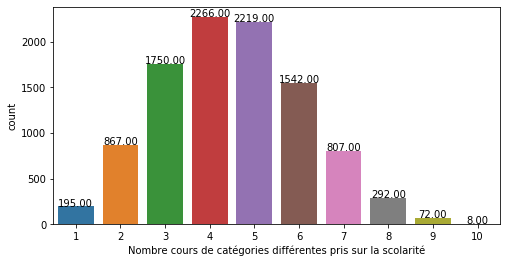

In [7]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x="CTO", data=df_tco)
ax.set_xlabel("Nombre cours de catégories différentes pris sur la scolarité")
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{:1.2f}".format(height),
            ha="center") 
fig = ax.get_figure()
fig.savefig("../graphs/431-répartition-cours.png")

### Statistics on "pure" univores
* Pure univore = student who has taken only 1 type of course on his whole academic track.
* Only 195 students in that case.
* Univore students are mostly specialized in marketing and finance.

In [8]:
# Filtering univores and displaying the category of the courses they mostly take
df_univore = df_tco[df_tco["CTO"]==1]
print(f"There are {df_univore.shape[0]} pure univore students.")
new_df = df.copy()
new_df["Hashed ID"] = new_df.apply(hash_function, axis=1)
df_univore_info = pd.merge(left=df_univore, right=new_df, left_on="Hashed ID", right_on="Hashed ID")
print("The categories of the courses pure univores take are as follows:")
df_univore_info['CODE_COURS'].value_counts()

There are 195 pure univore students.
The categories of the courses pure univores take are as follows:


MK    760
GF    379
RH     20
PG     12
GC      9
GG      2
MT      1
Name: CODE_COURS, dtype: int64

### Statistics on "pure" omnivores
* Pure omnivore = Students who have taken all the categories of courses on their whole academic track.
* Only 8 students in that case.

In [9]:
df_omnivore = df_tco[df_tco["CTO"]==10]
print(f"There are {df_omnivore.shape[0]} pure omnivore students.")
df_omnivore_info = pd.merge(left=df_omnivore, right=new_df, left_on="Hashed ID", right_on="Hashed ID")
print("The categories of the courses pure univores take are as follows:")
df_omnivore_info['CODE_COURS'].value_counts()

There are 8 pure omnivore students.
The categories of the courses pure univores take are as follows:


GF    31
PG    26
MK    20
MT    18
DR    16
ML    12
DS    12
EC    11
RH     9
GC     7
GG     7
Name: CODE_COURS, dtype: int64

### Categorising omnivorism levels

Defining 5 categories of omnivorism:
* Univore : 1 course taken
* Almost univore : 2 or 3 courses
* Omnivore : 4 or 5
* Very omnivore : 6 or 7
* Totally omnivore : 8 to 10

In [10]:
df_cat = df_tco
df_cat["CAT_OMNI"] = df_tco.apply(fn.omnivorism_cat, axis=1)

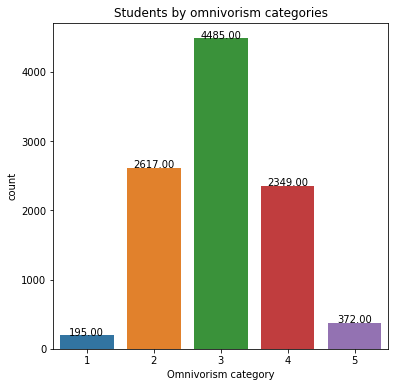

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(x="CAT_OMNI", data=df_cat)
ax.set_title("Students by omnivorism categories")
ax.set_xlabel("Omnivorism category")
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{:1.2f}".format(height),
            ha="center") 
fig = ax.get_figure()

### Studying omnivorism accross years

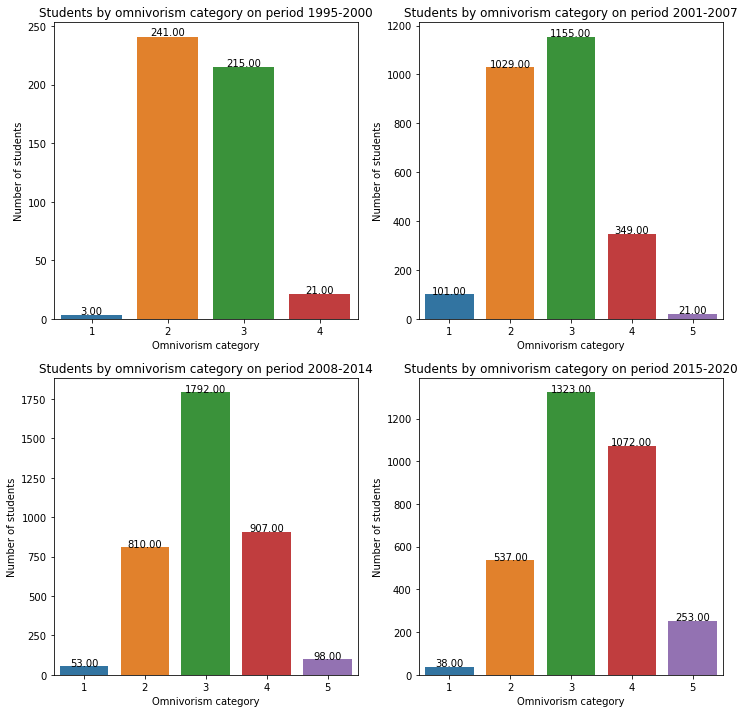

In [12]:
df_cat_with_year = pd.read_csv("../data/df_cat_with_year.csv")
df_cat_with_year_95_00 = df_cat_with_year.loc[(df_cat_with_year["EXERCICE"] >= 1995) & (df_cat_with_year["EXERCICE"] <= 2000)]
df_cat_with_year_01_07 = df_cat_with_year.loc[(df_cat_with_year["EXERCICE"] >= 2001) & (df_cat_with_year["EXERCICE"] <= 2007)]
df_cat_with_year_08_14 = df_cat_with_year.loc[(df_cat_with_year["EXERCICE"] >= 2008) & (df_cat_with_year["EXERCICE"] <= 2014)]
df_cat_with_year_15_20 = df_cat_with_year.loc[(df_cat_with_year["EXERCICE"] >= 2015) & (df_cat_with_year["EXERCICE"] <= 2020)]

dfs = [df_cat_with_year_95_00, df_cat_with_year_01_07,df_cat_with_year_08_14, df_cat_with_year_15_20]
periods = ["1995-2000", "2001-2007", "2008-2014", "2015-2020"]
fig, axes = plt.subplots(2,2, figsize = (12,12))

for ax, frame, period in zip(axes.flatten(), dfs, periods):
    ax = sns.countplot(x="CAT_OMNI", data=frame, ax=ax)
    ax.set_title(f"Students by omnivorism category on period {period}")
    ax.set_xlabel("Omnivorism category")
    ax.set_ylabel("Number of students")
    for p in ax.patches:
        height = int(p.get_height())
        ax.text(p.get_x()+p.get_width()/2.,
            height + 1.005,
            "{:1.2f}".format(height),
            ha="center") 

### Most taken courses by category

|Omnivorism category|Most taken course code|Most taken course name|
|----|----|----|
|<center>1</center>|<center>GF37</center>|Fixed Income: cash flow valuation and hedging|
|<center>2</center>|<center>MK20</center>|Technique de négociation-Mise en oeuvre|
|<center>3</center>|<center>MK20</center>|Technique de négociation-Mise en oeuvre|
|<center>4</center>|<center>GF106</center>|Maîtriser les fonda de l'analyse finan|
|<center>5</center>|<center>PGDIS</center>|Gouvernement d'entreprise (on line)|

In [13]:
df_cat_info = pd.merge(left=df_cat, right=new_df, left_on="Hashed ID", right_on="Hashed ID")
most_freq_crs_code = []
most_freq_crs_lib = []
most_freq_crs_nb_stud = []
for i in range(1,6):
    most_freq_crs_code.append(df_cat_info[df_cat_info['CAT_OMNI']==i].mode()["CODE_EPR"][0])
    most_freq_crs_lib.append(Counter.get_course_from_code(most_freq_crs_code[i-1]))
    most_freq_crs_nb_stud.append(fn.course_taken_nb(most_freq_crs_code[i-1], df_cat_info[df_cat_info["CAT_OMNI"]==i]))
    print(f"The most taken course for students in category {i} is {most_freq_crs_code[i-1]}\
: {most_freq_crs_lib[i-1]} with {most_freq_crs_nb_stud[i-1]} students")

../src/PFEmodules/counters.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset="CODE_EPR")[self.dataframe["CODE_EPR"] == course_code]["libepr"].to_string()


The most taken course for students in category 1 is MK14: Conduite des opérations marketing with 39 students
The most taken course for students in category 2 is MK14: Conduite des opérations marketing with 522 students
The most taken course for students in category 3 is GF12: Diagnostic financier with 1442 students
The most taken course for students in category 4 is GF12: Diagnostic financier with 957 students
The most taken course for students in category 5 is PGDIS1: Gouvernement d'entreprise (on line) with 187 students


### Studying distribution of courses in the various categories

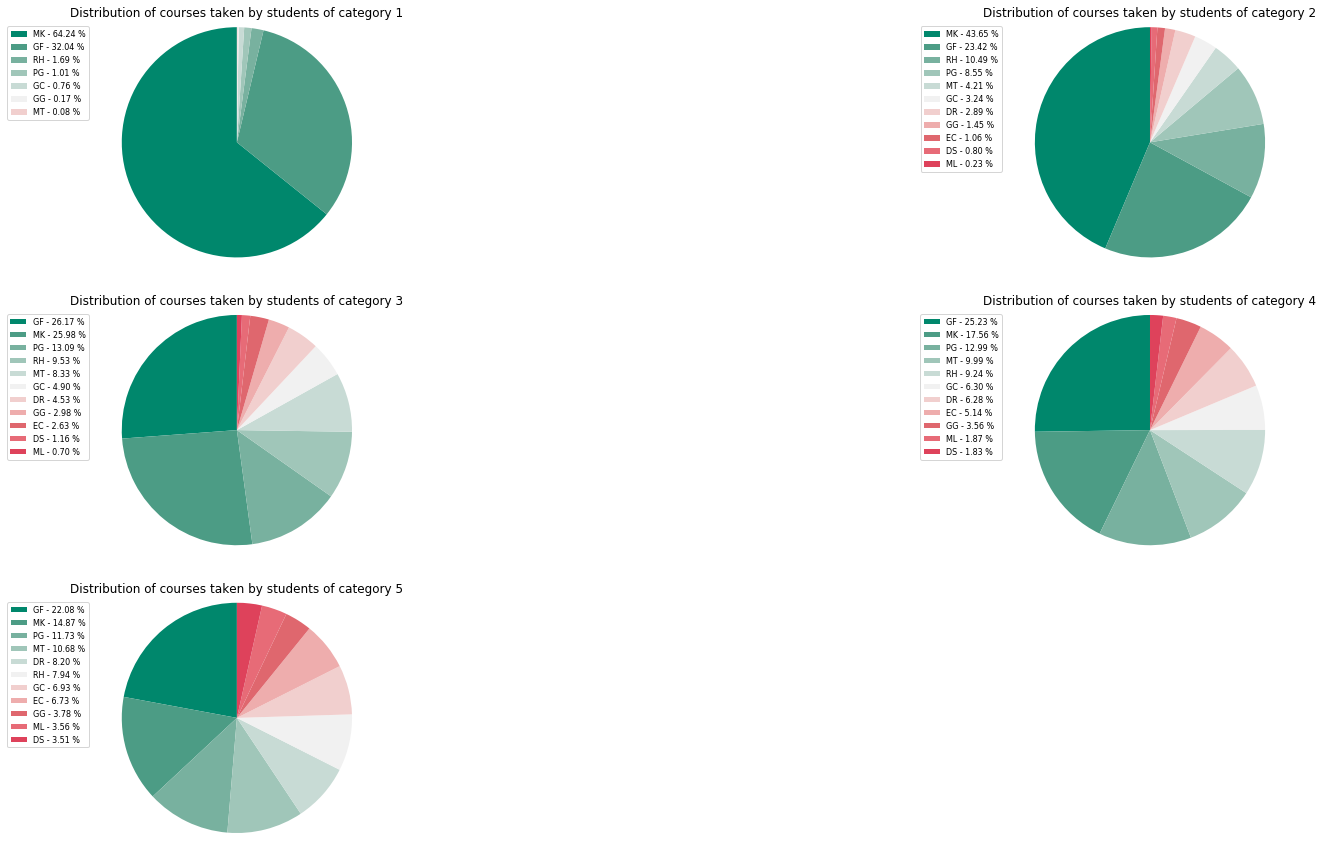

In [14]:
FreqCat = Frequency(df_cat_info)
FreqCat.plot_piecharts()